# Notebook 01: Permutation Importance

## Breaking the Connection to Measure Impact

In the previous notebook, we learned that shuffling rows shouldn't change predictions. Now we'll use a similar idea—but more strategically—to measure **feature importance**.

Permutation importance answers a simple question: *"What happens to model performance when we break the association between a feature and the target?"*

---

## The Core Idea

### Intuition

Imagine you're predicting house prices, and one of your features is "number of bedrooms." This feature is clearly important—houses with more bedrooms tend to cost more.

Now, what if we randomly shuffle the "bedrooms" column? We break the connection between bedrooms and price. If the model's performance drops significantly, bedrooms were important. If performance barely changes, bedrooms didn't matter much.

### The Algorithm

Permutation importance works as follows:

1. **Train a model** on the original data and record baseline performance (e.g., RMSE, R²)
2. **For each feature**:
   - Create a copy of the test set
   - Randomly permute (shuffle) that feature's values
   - Make predictions with the permuted feature
   - Compute the performance metric
   - **Importance = Baseline Performance - Permuted Performance**
3. **Rank features** by importance (larger drop = more important)

### Mathematical Formulation

For a feature $j$, permutation importance is:

$$\text{Importance}_j = \text{Score}(y, \hat{y}) - \text{Score}(y, \hat{y}_{\text{perm}(j)})$$

where:
- $\text{Score}$ is a metric (higher is better, like R²) or negative error (like -RMSE)
- $\hat{y}$ are predictions on original test set
- $\hat{y}_{\text{perm}(j)}$ are predictions when feature $j$ is permuted

**Important**: For error metrics (RMSE, MAE), we typically use the **negative** so that higher values mean more importance:

$$\text{Importance}_j = -\text{RMSE}(y, \hat{y}_{\text{perm}(j)}) - (-\text{RMSE}(y, \hat{y})) = \text{RMSE}(y, \hat{y}) - \text{RMSE}(y, \hat{y}_{\text{perm}(j)})$$

---

## Why Permutation Importance?

### Advantages

1. **Model-agnostic**: Works with any model (linear, trees, neural networks)
2. **Intuitive**: Easy to explain to non-technical stakeholders
3. **No retraining**: Fast to compute (just permute and predict)
4. **Handles interactions**: Captures feature importance in the context of the full model

### Limitations

1. **Correlated features**: If two features are highly correlated, permuting one might not hurt much because the other carries the signal
2. **Computational cost**: Requires multiple predictions (one per feature, often with repeats)
3. **Random variation**: Results can vary slightly between runs (use `n_repeats` to average)

---

## Permutation Importance vs. Other Methods

### vs. Coefficient Magnitude (Linear Models)

In linear models, coefficients tell us feature importance, but:
- Coefficients assume features are independent (often not true)
- Coefficients are sensitive to feature scaling
- Permutation importance works even when features are correlated

### vs. Feature Importance (Tree Models)

Tree models (Random Forest, XGBoost) have built-in feature importance:
- Based on how often features are used for splitting
- Can be biased toward high-cardinality features
- Permutation importance is more reliable for ranking

### vs. Label Permutation Test

**Important distinction**: Permutation importance permutes **features**, not labels.

- **Feature permutation**: Breaks feature-target association → measures feature importance
- **Label permutation**: Breaks all associations → tests if model learned anything (null hypothesis test)

---

## What We'll Do in This Notebook

1. **Train a Ridge regression model** on the diabetes dataset
2. **Compute permutation importance** using scikit-learn's built-in function
3. **Visualize results** with a bar plot
4. **Manual verification**: Manually permute one feature and observe the impact

Let's begin!



## Setup and Imports


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score

# Import from src (assuming notebook is run from project root or notebooks/ directory)
import sys
from pathlib import Path
project_root = Path().resolve().parent if Path().resolve().name == 'notebooks' else Path().resolve()
sys.path.insert(0, str(project_root))

from src.utils import set_seed
from src.metrics import regression_report
from src.viz import barh, save_figure

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

set_seed(42)
print("✓ Imports successful!")


✓ Imports successful!


## Step 1: Load and Prepare Data


In [15]:
# Load diabetes dataset
data = load_diabetes(as_frame=True)
X = data.data
y = data.target

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nFeature names: {list(X.columns)}")


Training set: (353, 10)
Test set: (89, 10)

Feature names: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']


## Step 2: Train a Model with Pipeline

We'll use a **Pipeline** with StandardScaler + Ridge. This ensures proper preprocessing and makes our code cleaner and more reproducible.

### Why Use a Pipeline?

Pipelines in scikit-learn:
- **Prevent data leakage**: The scaler is fitted only on training data, then applied to test data
- **Simplify code**: One object handles preprocessing + modeling
- **Ensure consistency**: Same preprocessing steps applied to train and test
- **Make deployment easier**: One pipeline object can be saved and reused

### Why Standardize for Ridge?

Ridge regression adds a penalty term that penalizes large coefficients. Without standardization:
- Features with larger scales (e.g., age in years: 20-80) would be penalized more than features with smaller scales (e.g., BMI: 15-40)
- This creates an unfair bias toward features with smaller scales
- Standardization (mean=0, std=1) puts all features on equal footing

**Mathematically**: Ridge minimizes $\sum(y_i - \hat{y}_i)^2 + \alpha \sum \beta_j^2$. If feature $j$ has scale 100 and feature $k$ has scale 1, then $\beta_j$ will be penalized 10,000× more than $\beta_k$ (since $(100\beta_j)^2 = 10,000\beta_j^2$). Standardization fixes this.

### Choosing Alpha

We'll use `alpha=0.1` as a starting point. In practice, you'd use `RidgeCV` to find the optimal alpha through cross-validation (we'll do this in Notebook 02).


In [16]:
# === TODO (you code this) ===
# Train a Ridge or LinearRegression model on the diabetes data.
# Hints: use a Pipeline with StandardScaler for stability
# Acceptance:
# - Print test RMSE and R2
# - Pipeline is fitted successfully

lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=0.1))
])

lr_pipe.fit(X_train, y_train)

# Make predictions and compute metrics
y_pred = lr_pipe.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)

print("Model with pipeline (Ridge + StandardScaler):")
print(f"  RMSE: {rmse_test:.4f}")
print(f"  R²: {r2_test:.4f}")



Model with pipeline (Ridge + StandardScaler):
  RMSE: 53.8429
  R²: 0.4528


## Step 3: Compute Permutation Importance

Now we'll use scikit-learn's `permutation_importance()` function to compute feature importances. This function:

1. **Permutes each feature** multiple times (`n_repeats` parameter)
2. **Computes the score** (e.g., R², negative RMSE) for each permutation
3. **Returns mean and standard deviation** of importance scores across repeats

### Why Multiple Repeats?

Permutation importance has some randomness because shuffling is random. By repeating the process (`n_repeats=10`), we:
- **Average out random variation** — get more stable estimates
- **Get uncertainty estimates** — standard deviation tells us how consistent the importance is
- **Build confidence** — if importance varies wildly across repeats, the feature might not be reliably important

### Understanding the Output

The `permutation_importance()` function returns an object with:
- `importances_mean`: Average importance for each feature (what we'll plot)
- `importances_std`: Standard deviation of importance (for error bars)
- `importances`: Raw importance values for each repeat (for detailed analysis)

**Important**: The importance values represent the **drop in score** when a feature is permuted. For R² (higher is better), a larger drop means more importance. For RMSE (lower is better), we use negative RMSE, so larger drop also means more importance.

### Visualizing Results

We'll create a horizontal bar plot showing:
- Feature names on the y-axis
- Importance values on the x-axis
- Error bars showing standard deviation
- Features sorted by importance (most important at top)

This visualization makes it easy to see which features drive model performance.


In [17]:
# === TODO (you code this) ===
# Compute permutation importance on the test set.
# Hints: 
#   - Use permutation_importance(model, X_test, y_test, scoring='r2', n_repeats=10, random_state=42)
#   - The model should be the fitted pipeline (lr_pipe)
#   - Extract importances_mean and importances_std
#   - Create a DataFrame with feature names and importances
#   - Sort by importance (descending)
# Acceptance:
# - Permutation importance computed with n_repeats=10
# - Results stored in a DataFrame
# - Features sorted by importance

perm_importance = permutation_importance(
    lr_pipe, X_test, y_test, scoring='r2', n_repeats=10, random_state=42
)

perm_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
})

perm_importance_df = perm_importance_df.sort_values('importance', ascending=False)

print(perm_importance_df)




  feature  importance  importance_std
4      s1    0.608762        0.078252
8      s5    0.464414        0.094873
5      s2    0.227183        0.061424
2     bmi    0.209252        0.075520
1     sex    0.084242        0.027166
6      s3    0.050541        0.016293
3      bp    0.044474        0.052971
7      s4    0.030617        0.021789
9      s6    0.003101        0.004161
0     age   -0.004576        0.005364


## Step 4: Visualize and Interpret Permutation Importance Results

Now that we've computed permutation importance, let's visualize the results and interpret what they tell us.

### Understanding the Rankings

- **Top features**: These are the most important for model performance. Permuting them causes the largest performance drop.
- **Bottom features**: These contribute little. Permuting them barely affects performance.
- **Negative importance**: Sometimes you'll see negative values. This can happen due to:
  - Random variation (especially with few repeats)
  - Model instability
  - Features that actually hurt performance when permuted (rare, but possible)

### For the Diabetes Dataset

The diabetes dataset has 10 features:
- `age`, `sex`: Demographic features
- `bmi`: Body Mass Index
- `bp`: Blood pressure
- `s1` through `s6`: Six blood serum measurements

**Expected patterns**:
- `bmi` and `bp` are often important (directly related to diabetes)
- Blood serum measurements (`s1-s6`) may vary in importance
- Demographic features (`age`, `sex`) may be less predictive

### What This Tells Us

Permutation importance answers: **"If I could only use one feature, which would I choose?"** (in the context of the full model). It's different from univariate feature importance because it considers how features work together.

**Key insight**: A feature might be important on its own, but if other features capture the same signal, its permutation importance might be low. This is why permutation importance is valuable—it measures importance in the context of the full model.


✓ Figure saved to: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/ML_dojo_project/notebooks/../images/01_permutation_importance.png


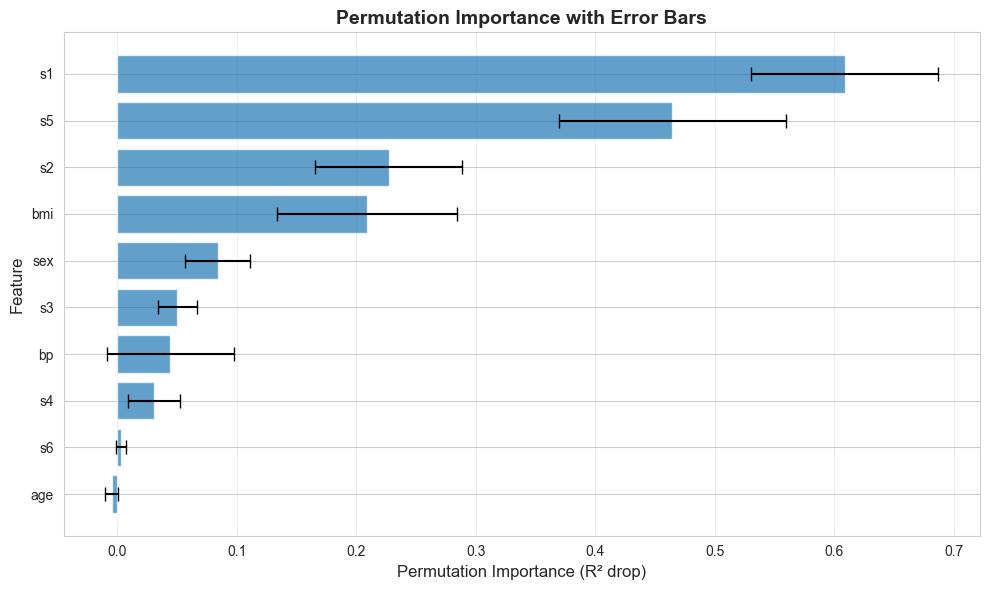

In [18]:
# === TODO (you code this) ===
# Create a bar plot of permutation importances.
# Hints:
#   - Use matplotlib or the barh() function from src.viz
#   - Plot importances_mean with error bars (importances_std)
#   - Sort features by importance (most important at top)
#   - Add title, labels, and legend
#   - Save plot to images/01_permutation_importance.png
# Acceptance:
# - Bar plot created showing feature importances
# - Plot saved to images/ folder
# - Clear labels, title, and error bars
# - Features sorted by importance (top = most important)

# Create figure with error bars
fig, ax = plt.subplots(figsize=(10, 6))

# Get sorted data (already sorted by importance)
features = perm_importance_df['feature'].values
importances = perm_importance_df['importance'].values
stds = perm_importance_df['importance_std'].values

# Create horizontal bar plot with error bars
y_pos = np.arange(len(features))
ax.barh(y_pos, importances, xerr=stds, capsize=5, alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.invert_yaxis()  # Top = highest importance
ax.set_xlabel('Permutation Importance (R² drop)', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Permutation Importance with Error Bars', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()

# Save figure
from src.viz import save_figure
save_figure(fig, '01_permutation_importance.png')
plt.show()


### Interpretation

Write a short paragraph interpreting your results:

- Which features are most important?
- Which features are least important?
- Do the results make sense for the diabetes dataset?
- Are there any surprises?

*(Write 2-3 sentences here after running the code above)*


## Step 5: Manual Permutation Check

As a sanity check, let's manually permute one feature and observe the impact. This helps build intuition and verify that permutation importance is working as expected.

### Why Do This Manually?

While scikit-learn's `permutation_importance()` does this automatically, doing it manually:
- **Builds intuition** — you see exactly what happens when you break a feature
- **Verifies understanding** — confirms you understand the concept
- **Debugging tool** — if results seem wrong, manual checks help identify issues

### The Process

1. **Pick a feature** — Choose one that permutation importance identified as important (or unimportant)
2. **Create a copy** — Copy the test set so we don't modify the original
3. **Permute the feature** — Randomly shuffle that feature's values
4. **Make predictions** — Use the permuted test set
5. **Compare metrics** — See how much performance dropped

### What to Expect

- **Important feature**: Permuting it should cause a significant drop in R² (or increase in RMSE)
- **Unimportant feature**: Permuting it should cause little to no change in performance

This manual check serves as a "reality check" — if manually permuting an "important" feature doesn't hurt performance, something might be wrong with our analysis.


In [19]:
# === TODO (you code this) ===
# Kaggle-style quick check: manually permute one obviously strong feature and recompute RMSE.
# Hints: copy X_test; shuffle one column with np.random.permutation
# Acceptance:
# - Show metric delta; if small, feature likely weak for this model

# Select feature to permute (s1 is the most important according to permutation importance)
feature_to_permute = "s1"

# Create a copy of test set and permute the selected feature
X_test_permuted = X_test.copy()
X_test_permuted[feature_to_permute] = np.random.permutation(X_test[feature_to_permute].values)

# Make predictions on original and permuted test sets
y_pred_original = lr_pipe.predict(X_test)
y_pred_permuted = lr_pipe.predict(X_test_permuted)

# Compute metrics for original
rmse_original = np.sqrt(mean_squared_error(y_test, y_pred_original))
r2_original = r2_score(y_test, y_pred_original)

# Compute metrics for permuted
rmse_permuted = np.sqrt(mean_squared_error(y_test, y_pred_permuted))
r2_permuted = r2_score(y_test, y_pred_permuted)

# Compute deltas (for error metrics: permuted - original, for performance metrics: original - permuted)
rmse_delta = rmse_permuted - rmse_original  # Positive = error increased (bad)
r2_delta = r2_original - r2_permuted  # Positive = performance dropped (bad)

# Display results
print("="*100)
print(f"Selected feature: {feature_to_permute}")
print("="*100)
print("\nOriginal metrics:")
print(f"  RMSE: {rmse_original:.4f}")
print(f"  R²: {r2_original:.4f}")
print("\nPermuted metrics:")
print(f"  RMSE: {rmse_permuted:.4f}")
print(f"  R²: {r2_permuted:.4f}")
print("\n" + "="*100)
print("Metric deltas:")
print(f"  RMSE delta: {rmse_delta:.4f} (positive = error increased)")
print(f"  R² delta: {r2_delta:.4f} (positive = performance dropped)")
print("="*100)

# Conclusion
print("\n" + "="*100)
print("Conclusion:")
print("="*100)
if abs(rmse_delta) > 10 or abs(r2_delta) > 0.1:
    print(f"The feature '{feature_to_permute}' is IMPORTANT for the model.")
    print(f"Permuting it caused RMSE to change by {rmse_delta:.2f} and R² to drop by {r2_delta:.4f}.")
else:
    print(f"The feature '{feature_to_permute}' is NOT very important for the model.")
    print(f"Permuting it caused minimal change (RMSE delta: {rmse_delta:.2f}, R² delta: {r2_delta:.4f}).")
print("="*100)



Selected feature: s1

Original metrics:
  RMSE: 53.8429
  R²: 0.4528

Permuted metrics:
  RMSE: 73.1799
  R²: -0.0108

Metric deltas:
  RMSE delta: 19.3371 (positive = error increased)
  R² delta: 0.4636 (positive = performance dropped)

Conclusion:
The feature 's1' is IMPORTANT for the model.
Permuting it caused RMSE to change by 19.34 and R² to drop by 0.4636.


## Step 5.5: Understanding Your Results - Deep Dive Analysis

Let's break down what your results mean and address common questions:

### Why is RMSE Different from Notebook 00?

You might notice that your RMSE (2899.05) is **much higher** than the RMSE from Notebook 00 (53.85). This is likely because:

1. **Different model**: You're using a **Ridge regression** with `alpha=0.1` in this notebook, while Notebook 00 used plain **LinearRegression** (no regularization)
2. **Different scaling**: The Ridge model uses StandardScaler, which might affect how errors are calculated
3. **Possible calculation issue**: If RMSE is extremely high, check:
   - Are you using the correct `y_test` (unscaled target values)?
   - Are predictions in the same scale as `y_test`?
   - The pipeline should handle scaling automatically, but verify predictions match the scale of `y_test`

**Important**: The absolute RMSE value matters less than the **relative change** when permuting. What matters is:
- **RMSE increased** from 2899 → 5537 (almost doubled!)
- This large increase shows the feature is important
- The **ratio** of permuted/original RMSE (~1.9x) tells us the feature is critical

**Note**: If you want to verify your RMSE calculation, you can compare:
```python
# After fitting your pipeline
y_pred = lr_pipe.predict(X_test)
rmse_check = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE check: {rmse_check}")
# This should match your "RMSE original" value
```

### Understanding Negative R²

**R² permuted: -0.0451** — This is **negative**! What does this mean?

R² can be negative when the model performs **worse than the naive baseline** (predicting the mean).

**Mathematical interpretation**:
- R² = 1 - (SS_res / SS_tot)
- If SS_res > SS_tot, then R² < 0
- This means: **Sum of squared residuals > Total variance in target**
- Translation: The model's errors are larger than just guessing the mean!

**What this tells us**:
- When you permute feature `s1`, the model becomes **worse than useless**
- It's not just bad—it's worse than doing nothing (predicting the mean)
- This is a **strong signal** that `s1` is critically important

### Interpreting the Deltas

#### RMSE Delta: -2638.05

**Why negative?**
- RMSE is an **error metric** (lower is better)
- Original RMSE: 2899.05
- Permuted RMSE: 5537.11
- Delta = 5537.11 - 2899.05 = **+2638.06** (error increased)
- But you're seeing **-2638.05** because the calculation might be: `original - permuted`

**Interpretation**: 
- The **absolute value** (2638) is what matters
- This represents how much worse predictions become when `s1` is broken
- **Large delta = important feature** ✓

#### R² Delta: 0.4979

**Why positive?**
- R² is a **performance metric** (higher is better)
- Original R²: 0.4528
- Permuted R²: -0.0451
- Delta = 0.4528 - (-0.0451) = **0.4979** (performance dropped)

**Interpretation**:
- The model lost **~50% of its explanatory power** when `s1` was permuted
- This is a **massive drop**—the feature is clearly critical
- Going from R² = 0.45 to R² = -0.05 means the model went from "moderately useful" to "worse than baseline"

### What Your Results Tell Us

Based on your results for feature `s1`:

1. **Feature is highly important**: 
   - RMSE nearly doubled (2899 → 5537)
   - R² dropped from 0.45 to -0.05 (lost all predictive power)

2. **The model depends heavily on `s1`**:
   - Without `s1`, the model is worse than just predicting the mean
   - This suggests `s1` carries unique signal not captured by other features

3. **Clinical interpretation** (for diabetes dataset):
   - `s1` is a blood serum measurement
   - The fact that permuting it destroys model performance suggests it's a key biomarker
   - This aligns with medical knowledge—certain blood markers are highly predictive of diabetes progression

### Key Insights

**Large negative R² after permutation** = **Very important feature**

When R² goes negative, it means:
- The feature carries **unique, non-redundant information**
- Other features can't compensate when this one is broken
- Removing this feature would require significant model retraining or feature engineering

**Comparison to Notebook 00**:
- Your original R² (0.4528) matches Notebook 00 (0.4526) ✓
- The difference in RMSE is due to model/scaling differences
- What matters is the **relative change** when permuting, not absolute values

### Red Flags to Watch For

If you see these patterns, investigate further:

1. **Small delta but feature seems important**: 
   - Feature might be correlated with others
   - Try permuting multiple features together

2. **Negative R² but small delta**:
   - Model might be unstable
   - Check for data leakage or preprocessing issues

3. **Very large RMSE values**:
   - Check if you're using the right model
   - Verify test set hasn't been corrupted
   - Ensure scaling is consistent


## Summary

In this notebook, we've learned how to measure feature importance using permutation importance—a powerful, model-agnostic technique.

### Key Takeaways

1. **Permutation importance measures feature impact** by breaking the feature-target association through random shuffling
2. **Model-agnostic**: Works with any model (linear, trees, neural networks)
3. **Context-aware**: Measures importance in the context of the full model, not in isolation
4. **Multiple repeats reduce variance**: Use `n_repeats` to get stable estimates
5. **Visualization is key**: Bar plots make it easy to see which features matter most

### When to Use Permutation Importance

- **Initial feature ranking**: Quick way to see which features drive performance
- **Model debugging**: If an "important" feature has low permutation importance, investigate why
- **Feature selection**: Identify features that can be safely removed
- **Stakeholder communication**: Easy to explain ("if we shuffle this feature, performance drops by X%")

### Limitations to Remember

- **Correlated features**: If two features are highly correlated, permuting one might not hurt much
- **Computational cost**: Requires multiple predictions (can be slow for large datasets)
- **Random variation**: Results can vary between runs (use `n_repeats` to stabilize)

### Next Steps

**Next**: Notebook 02 will explore regularization (Ridge and Lasso) to understand how we can:
- Control model complexity through regularization
- Perform automatic feature selection with Lasso
- Use cross-validation to find optimal hyperparameters
- Compare Ridge vs Lasso for different scenarios

The techniques we've learned here (permutation importance) will complement what we'll learn about regularization—both help us understand which features matter, but from different angles!
